In [2]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

## Bae control

In [5]:
arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
bae_ddG = pd.read_table('./data/literature/Bae_mismatch.tsv', sep='\t').set_index('mismatch')

In [98]:
def find_mismatch_parent(s:str, ref:pd.Series):
    
    # found = False
    parent, tag = 'na', 'na'
    
    if s in ref.values:
        parent = ref[ref == s].index[0]
        tag = '-'
    
    
    for i,r in enumerate(ref):

        if len(s) == len(r):
            n_same, n_diff = 0, 0
            for j in range(len(r)):
                if s[j] == r[j]:
                    n_same += 1

            if n_same + 1 == len(r):
                found = True
                parent = ref.index[i]
                for j in range(len(r)):
                    if s[j] != r[j]:
                        tag = f'{r[j]}>{s[j]}'
                        break
                        
    return parent, tag

def adjust_salt_dG_37(row):
    return util.get_Na_adjusted_dG_37(row.Tm, row.dH, row.GC, Na=0.161, from_Na=0.088)

In [99]:
df = arr.query('ConstructType == "BaeControls"')
ref = df.loc[['BC%d'%i for i in range(6)],'RefSeq']

# Avoid terminal AT fraying
df = df.loc[df.RefSeq.apply(lambda x: x.startswith('C'))]

result = df.RefSeq.apply(lambda s: find_mismatch_parent(s, ref))
df[['parent', 'mismatch']] = np.array([list(x) for x in result.values])

bae_compare = df.join(bae_ddG.loc[:,'37'], on='mismatch', how='left').dropna(subset=['37'])
bae_compare['parent_dG_37'] = bae_compare.parent.apply(lambda x: adjust_salt_dG_37(df.loc[x,:]))
bae_compare['parent_dG_37_se'] = bae_compare.parent.apply(lambda x: df.loc[x,'dG_37_se'])
bae_compare['dG_37_adjusted'] = adjust_salt_dG_37(bae_compare)

bae_compare['ddG_37'] = bae_compare['dG_37_adjusted'] - bae_compare['parent_dG_37']
bae_compare['ddG_37_se'] = bae_compare['dG_37_se'] + bae_compare['parent_dG_37_se']

mm_dict = {'G>A':0, 'G>T':1, 'G>C':2}
bae_compare['mismatch_index'] = bae_compare['mismatch'].apply(lambda x: mm_dict[x])
bae_compare['mismatch_index'] += [-.01]*3

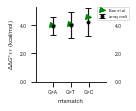

In [100]:
fig, (ax, lax) = plt.subplots(1, 2, figsize=(4.25*cm, 3.5*cm), gridspec_kw={"width_ratios":[5,1]})
ax.errorbar(x=bae_compare.mismatch_index, y=bae_compare.ddG_37, yerr= bae_compare.ddG_37_se,
             fmt='o', capsize=3, markersize=3, color='k', alpha=0.9,
            label='array melt')
ax.plot(np.arange(3)-0.05, bae_compare['37'], 'g>', markersize=5, label='Bae et al.')
ax.set_ylim(bottom=0)
ax.set_xlim((-1,3))

ax.legend()
ax.get_legend().remove()

sns.despine()
ax.set_xlabel('mismatch', fontsize=label_font_size)
ax.set_ylabel('$\Delta \Delta G°_{37}$ (kcal/mol)', fontsize=label_font_size)

ax.set_xticks(np.arange(3))
ax.set_xticklabels(mm_dict, fontsize=tick_font_size)
ax.set_yticklabels([0.0,2.0,4.0], fontsize=tick_font_size, visible=True)


h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, prop={'size': 4})
lax.axis("off")

util.save_fig('./fig/Bae/ddG_mismatch_compare.pdf')

In [68]:
ax.get_yticklabels()

[Text(0, 0.0, ''), Text(0, 2.0, ''), Text(0, 4.0, ''), Text(0, 6.0, '')]

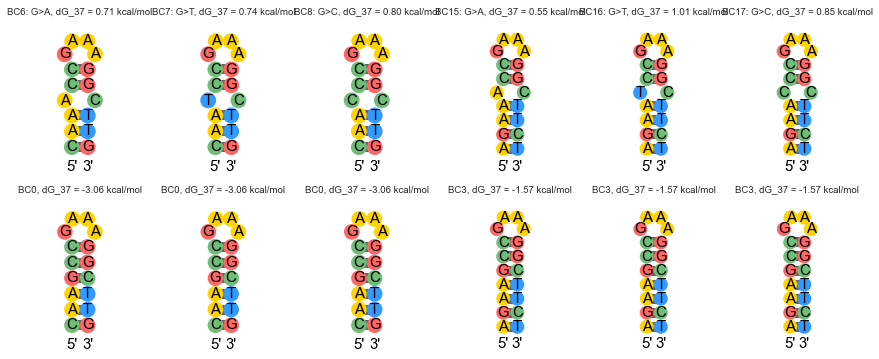

In [11]:
fig, ax = plt.subplots(2, 6, figsize=(15,6))
j = 0
for i in (6,7,8,15,16,17):
    seqid = 'BC%d'%i
    if seqid in df.index:
        draw_struct(df.loc[seqid, 'RefSeq'], df.loc[seqid, 'TargetStruct'], ax=ax[0][j])
        parent = df.loc[seqid, 'parent']
        draw_struct(df.loc[parent, 'RefSeq'], df.loc[parent, 'TargetStruct'], ax=ax[1][j])
        ax[0][j].set_title('%s: %s, dG_37 = %.2f kcal/mol' % (seqid, df.loc[seqid, "mismatch"], df.loc[seqid, "dG_37"]))
        ax[1][j].set_title('%s, dG_37 = %.2f kcal/mol' % (parent, df.loc[parent, "dG_37"]))
        j += 1
    
util.save_fig('./fig/Bae/structures_plotted.pdf')

## Fig. 2C 

### SantaLucia Mismatch

#### Prepare data from literature

In [121]:
sl_mm = pd.read_csv('./data/literature/SantaLucia_single_mismatch.csv', index_col=0)
sl_mm['isWC'] = sl_mm.dG_37.apply(lambda x: x == 'WC')
sl_wc = pd.read_csv('./data/literature/SantaLucia_full.tsv', sep='\t', index_col=0)

In [122]:
def add_wc(row):
    if row.dG_37 == 'WC':
        return float(sl_wc.loc[row.name, 'dG_37'])
    else:
        return float(row.dG_37)
    
sl_mm['dG_37'] = sl_mm.apply(add_wc, axis=1)

In [123]:
sl_mm['dG_37_parent'] = sl_mm.apply(lambda row: sl_mm.loc[row['parent'], 'dG_37'], axis=1)
sl_mm['ddG_37'] = sl_mm['dG_37'] - sl_mm['dG_37_parent']
sl_mm['ddG_37'] = sl_mm['dG_37'] - sl_mm['dG_37_parent']

In [124]:
sl_mm

,dG_37,base_stack,parent,mismatch,isWC,dG_37_parent,ddG_37
GA_AC,0.17,G_C,GT_AC,T>A,False,-1.44,1.61
GC_AC,0.47,G_C,GT_AC,T>C,False,-1.44,1.91
GG_AC,-0.52,G_C,GT_AC,T>G,False,-1.44,0.92
GT_AC,-1.44,G_C,GT_AC,-,True,-1.44,0.00
CA_AG,0.43,C_G,CT_AG,T>A,False,-1.28,1.71
...,...,...,...,...,...,...,...
AT_TT,0.69,A_T,AA_TT,A>T,False,-1.00,1.69
TA_TA,-0.58,T_A,TA_TA,-,True,-0.58,0.00
TC_TA,0.97,T_A,TA_TA,A>C,False,-0.58,1.55
TG_TA,0.43,T_A,TA_TA,A>G,False,-0.58,1.01


In [125]:
pd.pivot_table(sl_mm, values='ddG_37', index='base_stack', columns='mismatch', aggfunc='max') - \
pd.pivot_table(sl_mm, values='ddG_37', index='base_stack', columns='mismatch', aggfunc='min')

mismatch,-,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
base_stack,,,,,,,,,,,,,
A_T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C_G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G_C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T_A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='mismatch', ylabel='base_stack'>

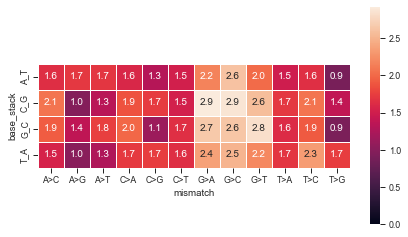

In [126]:
fig, ax = plt.subplots(figsize=(7,4))
sns.heatmap(pd.pivot_table(sl_mm, values='ddG_37', index='base_stack', columns='mismatch').drop(columns='-'),
            annot=True, fmt='.1f', vmin=0,
            square=True,
            linewidth=1)

### Compare Mismatches

In [107]:
def adjust_salt_dG_37_1M(row):
    return util.get_Na_adjusted_dG_37(row.Tm, row.dH, row.GC, Na=1, from_Na=0.088)

arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
arr['dG_37_1M_Na'] = arr.apply(adjust_salt_dG_37_1M, axis=1)

In [108]:
def replace_at_index(s:str, newstring:str, idx:int):
    return s[:idx] + newstring + s[idx + 1:]
  
def find_mm_parent(seq, struct, arr):
    def get_parent_candidates(seq, struct):
        if '.(.' in struct:
            return None, None
        
        bp_dict = dict(A='T', C='G', T='A', G='C')
        idxmm = (('('+struct).find('((.(') + 1, (struct+')').find(').))') + 1)
        if idxmm[0] == 0 or idxmm[1] == 1:
            return None, None
        else:
            parent1 = replace_at_index(seq, bp_dict[seq[idxmm[0]]], idxmm[1])
            mm1 = bp_dict[seq[idxmm[0]]] + '>' + seq[idxmm[1]]
            parent2 = replace_at_index(seq, bp_dict[seq[idxmm[1]]], idxmm[0])
            mm2 = bp_dict[seq[idxmm[1]]] + '>' + seq[idxmm[0]]
            context = seq[idxmm[0]-1:idxmm[0]] + '.' + seq[idxmm[0]+1: idxmm[0]+2]
            return {parent1: mm1, parent2: mm2}, context
        
    parent_candidates, context = get_parent_candidates(seq, struct)
    
    if parent_candidates is None:
        return np.nan
    
    idx_parent = None
    for candidate in parent_candidates:
        try:
            idx_parent = arr.RefSeq.tolist().index(candidate)
            mm = parent_candidates[candidate]
        except:
            continue
            
    if idx_parent is None:
        return np.nan
    else:
        return (arr.iloc[idx_parent].name, mm, context)

In [109]:
df = arr.query("ConstructType == 'BaeControls' | Series == 'MisMatches'")
df['parent'] = df.apply(lambda row: find_mm_parent(row.RefSeq, row.TargetStruct, arr), axis=1)
df.dropna(subset=['parent'], inplace=True)

In [110]:
df['mismatch'] = df.parent.apply(lambda x: x[1])
df['context'] = df.parent.apply(lambda x: x[2])
df['parent'] = df.parent.apply(lambda x: x[0])
df['has_parent'] = df.parent.apply(lambda x: x in arr.index.tolist())

In [111]:
df = df.query('has_parent')

In [112]:
df['base_stack'] = df.context.apply(lambda x: x[0] + '_' + bp_dict[x[0]])

In [113]:
df['ddG_37'] = df['dG_37_1M_Na'] - df.parent.apply(lambda x: arr.loc[x, 'dG_37_1M_Na'])

#### Heatmaps

<AxesSubplot:xlabel='mismatch', ylabel='base_stack'>

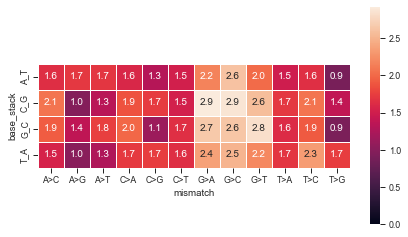

In [127]:
fig, ax = plt.subplots(figsize=(7,4))
sns.heatmap(pd.pivot_table(sl_mm, values='ddG_37', index='base_stack', columns='mismatch').drop(columns='-'),
            annot=True, fmt='.1f', vmin=0,
            square=True,
            linewidth=1)

<AxesSubplot:xlabel='mismatch', ylabel='base_stack'>

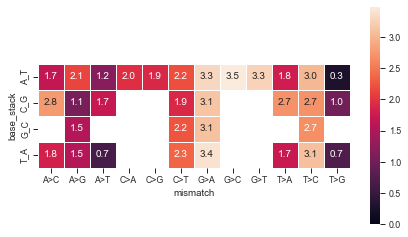

In [186]:
fig, ax = plt.subplots(figsize=(7,4))
sns.heatmap(pd.pivot_table(df, values='ddG_37', index='base_stack', columns='mismatch'),
            annot=True, fmt='.1f', vmin=0, #cmap='Reds',
            square=True,
            linewidth=1)

# sns.heatmap(pd.pivot_table(df, values='ddG_37', index='base_stack', columns='mismatch', aggfunc='std'),
#             annot=True, fmt='.1f', vmin=0,
#             square=True,
#             linewidth=1)

<AxesSubplot:xlabel='mismatch', ylabel='base_stack'>

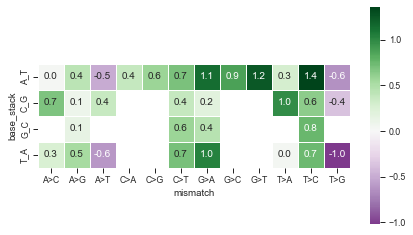

In [114]:
sl_mm_pivot = pd.pivot_table(sl_mm, values='ddG_37', index='base_stack', columns='mismatch').drop(columns='-')
array_mm_pivot = pd.pivot_table(df, values='ddG_37', index='base_stack', columns='mismatch')

fig, ax = plt.subplots(figsize=(7,4))
sns.heatmap(array_mm_pivot - sl_mm_pivot,
            annot=True, fmt='.1f', center=0, cmap='PRGn',
            square=True,
            linewidth=1)

#### All mismatches strip plot

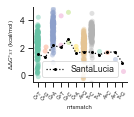

In [184]:
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))

sns.stripplot(data=df.query('base_stack == "A_T"'),
             y='ddG_37',
             x='mismatch',
             alpha=.4,
             palette='Set2',
             ax=ax)
xticks = [x.get_text() for x in ax.get_xticklabels()]
ax.plot(xticks, sl_mm_pivot.loc['A_T', xticks],
        'k:o', zorder=10, markersize=2, label='SantaLucia')
plt.legend()
ax.set_ylim([-.5,5])

ax.set_xlabel('mismatch', fontsize=label_font_size)
ax.set_ylabel('$\Delta \Delta G°_{37}$ (kcal/mol)', fontsize=label_font_size)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_font_size, rotation=45)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_font_size)

sns.despine()

util.save_fig('./fig/Fig2/single_mm.pdf')

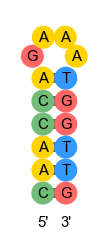

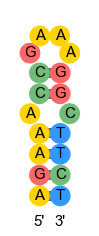

In [12]:
fig, ax = plt.subplots()
draw_struct('CAACCAGAAATGGTTG', '((((((....))))))', ax=ax)
util.save_fig('./fig/Fig2/Fig2A_struct1.pdf', fig)
fig, ax = plt.subplots()
draw_struct('AGAAACCGAAAGGCTTCT', '((((.((....)).))))', ax=ax)
util.save_fig('./fig/Fig2/Fig2A_struct2.pdf', fig)

#### Breakdown by location

In [130]:
np.unique(df.ConstructType)

array(['3mer', 'AC_mismatch_varpos', 'BaeControls', 'Centered',
       'GT_mismatch_varpos'], dtype=object)

In [133]:
np.unique(df.query('ConstructType == "AC_mismatch_varpos"').TargetStruct)

array(['((((.((....)).))))', '(((.(((....))).)))', '((.((((....)))).))',
       '(.(((((....))))).)'], dtype=object)

In [147]:
acmm_df.base_stack

SEQID
MMACP10      A_T
MMACP1006    C_G
MMACP1007    C_G
MMACP1008    C_G
MMACP1009    C_G
            ... 
MMACP991     G_C
MMACP993     G_C
MMACP994     G_C
MMACP995     G_C
MMACP996     G_C
Name: base_stack, Length: 1750, dtype: object

In [135]:
acmm_df = df.query('ConstructType == "AC_mismatch_varpos"')
acmm_df['mismatch_loc'] = acmm_df.TargetStruct.apply(lambda x: x.find('.'))

In [152]:
'-'.join(sorted(['G','C']))

'C-G'

In [166]:
acmm_df['lower_stack'] = acmm_df.context.apply(lambda x: '-'.join(sorted([x[0], bp_dict[x[0]]])))
acmm_df['upper_stack'] = acmm_df.context.apply(lambda x: '-'.join(sorted([x[-1], bp_dict[x[-1]]])))
acmm_df['neighbor_stacks'] = acmm_df.apply(lambda row: row.lower_stack + ' x ' + row.upper_stack, axis=1)

<AxesSubplot:xlabel='context', ylabel='ddG_37'>

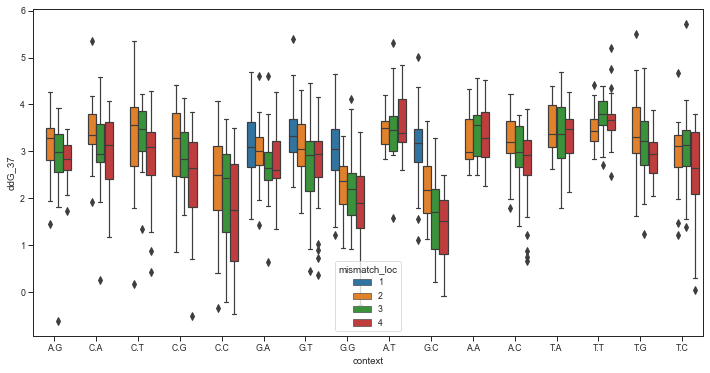

In [175]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(data=acmm_df, hue='mismatch_loc', y='ddG_37', x='context')
             

<AxesSubplot:xlabel='neighbor_stacks', ylabel='ddG_37'>

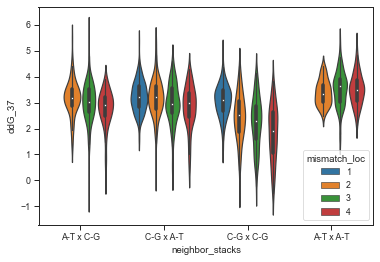

In [169]:
sns.violinplot(data=acmm_df, hue='mismatch_loc', y='ddG_37', x='neighbor_stacks')

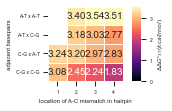

In [196]:
fig, ax = plt.subplots(1, 2, figsize=(4.25*cm, 3.5*cm), gridspec_kw={"width_ratios":[8,1]})
sns.heatmap(pd.pivot_table(acmm_df, values='ddG_37', index='neighbor_stacks', columns='mismatch_loc'),
            annot=True, fmt='.2f', vmin=0, #label_font_size=label_font_size,
            square=True, cmap='magma', ax=ax[0], cbar_ax=ax[1], cbar_kws=dict(drawedges=False),
            linewidth=1)
ax[0].set_xlabel('location of A-C mismatch in hairpin', fontsize=label_font_size)
ax[0].set_ylabel('adjacent basepairs', fontsize=label_font_size)

ax[1].tick_params(labelsize=tick_font_size)
ax[1].set_ylabel('$\Delta \Delta G°_{37} (kcal/mol)$', size=label_font_size)

ax[0].tick_params(axis='both', which='major', labelsize=tick_font_size)
util.save_fig('./fig/Fig2/Fig2C_AC_mismatch_breakdown_by_context_position.pdf')

<AxesSubplot:xlabel='mismatch_loc', ylabel='neighbor_stacks'>

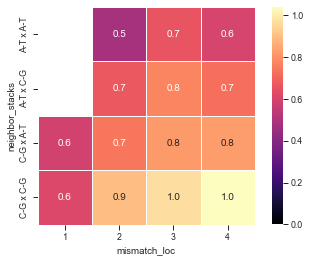

In [194]:
sns.heatmap(pd.pivot_table(acmm_df, values='ddG_37', index='neighbor_stacks', columns='mismatch_loc', aggfunc='std'),
            annot=True, fmt='.1f', vmin=0, #label_font_size=label_font_size,
            square=True, cmap='magma', 
            linewidth=1)

## Supp Fig. 2B WC68

In [4]:
# reading fitted parameters into a single DataFrame
conc = [1, 2, 4, 6, 8, 10, 12]
datadir = './data/uv_melt/archive/UVmelting_WC68_1M/'
cols_p = ['dH', 'Tm', 'fmax', 'fmin', 'slopel', 'slopeu']
cols_se = [c+'_se' for c in cols_p]
cols = ['conc', 'curve_name'] + cols_p + cols_se
uv_melt_df = pd.DataFrame(columns=cols)

for i in range(1, 8):
    for curve_name in ['MeltingCurve', 'CoolingCurve', 'SecondaryMeltingCurve', 'SecondaryCoolingCurve']:
        df = pd.read_csv(os.path.join(datadir, 'WC68_conc%d_%s.csv') % (i, curve_name), header=None, index_col=0)
        row_dict = {**dict(conc=conc[i-1], curve_name=curve_name), **{c: df.loc[c, 1] for c in cols_p}, **{c+'_se': df.loc[c, 2] for c in cols_p}}
        uv_melt_df = uv_melt_df.append(row_dict, ignore_index=True)

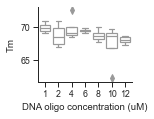

In [15]:
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
# sns.stripplot(data=uv_melt_df, y='Tm', x='conc', hue='curve_name', marker='D', palette='magma', ax=ax)
sns.boxplot(data=uv_melt_df, y='Tm', x='conc', color='white', ax=ax)
adjusted_Tm = util.get_Na_adjusted_Tm(arr.loc['WC68', 'Tm'], arr.loc['WC68', 'dH'], arr.loc['WC68', 'GC'], Na=1.0, from_Na=0.088)
# ax.errorbar(7, adjusted_Tm, yerr=arr.loc['WC68', 'Tm_se'], fmt='.', c='g', capsize=5, markersize=12, label='measurement (low salt)')
# ax.errorbar(8, arr.loc['WC68', 'Tm_NUPACK'], fmt='.', c='k', capsize=5, markersize=12, label='NUPACK')
# ax.set_ylim(top=-20)
# plt.legend()
sns.despine()

ax.set_xlabel('DNA oligo concentration (uM)')
util.save_fig('./fig/UV_melt/WC68_fitted_Tm_conc_suppfig2.pdf')

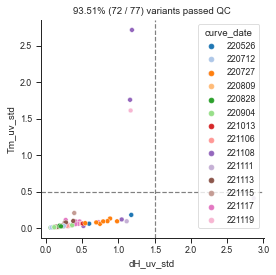

In [18]:
result_df = pd.read_csv('./data/uv_melt/uvmelt_221121.csv', index_col=0).query('pass_qc')
sample_sheet_file = './data/uv_melt/ECLSampleSheet221121.csv'
result_agg_df = uv.agg_fit_result(uvmelt_result_file='./data/uv_melt/uvmelt_221121.csv',
                               agg_result_file='./data/uv_melt/uvmelt_agg_221121.csv',
                               sample_sheet_file=sample_sheet_file, clean=True)

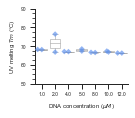

In [106]:
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
df = result_df.query('SEQID == "WC68" & (curve_name == "CoolingCurve" | curve_name == "SecondaryCoolingCurve")')
sns.swarmplot(data=df, y='Tm', x='conc_uM', #hue='curve_name', 
              color='cornflowerblue', alpha=.7, marker='D', size=4, ax=ax)
# ax.get_legend().remove()
sns.boxplot(data=df, y='Tm', x='conc_uM', color='white', linewidth=.5, ax=ax)

ax.set_xlabel('DNA concentration ($\mu M$)', fontsize=label_font_size)
ax.set_ylabel('UV melting $Tm$ (°C)', fontsize=label_font_size)
plt.ylim([50,90])
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_font_size)
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2.5))
ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

sns.despine()
util.save_fig('./fig/Fig2/SuppFig2B_WC68_conc.pdf')

<AxesSubplot:xlabel='conc_uM', ylabel='OD'>

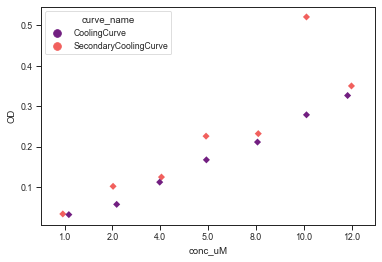

In [41]:
df['OD'] = df.fmax - df.fmin
sns.stripplot(data=df, y='OD', x='conc_uM', hue='curve_name', marker='D', palette='magma')